In [69]:
import numpy as np
import pandas as pd

from sklearn import svm
import glob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from scipy.sparse import hstack
from sklearn import svm
import time
import numpy as np
#from sklearn.model_selection import validation_curve
from sklearn.datasets import load_iris
from sklearn.linear_model import Ridge
from sklearn.svm import SVC, LinearSVC
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
#import matplotlib_venn as venn
%matplotlib inline

In [4]:
import keras
from keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU
from keras.callbacks import Callback
from keras.layers import Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten
from keras.preprocessing import text, sequence
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\hudie\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hudie\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hudie\AppData\Roaming\Pyth

In [7]:
train_pos_path = 'C:\\Users\\hudie\\Downloads\\aclImdb\\train\\pos'
train_neg_path = 'C:\\Users\\hudie\\Downloads\\aclImdb\\train\\neg'
test_pos_path = 'C:\\Users\\hudie\\Downloads\\aclImdb\\test\\pos'
test_neg_path = 'C:\\Users\\hudie\\Downloads\\aclImdb\\test\\neg'


In [8]:
train_pos_reviews = [pd.read_csv(filename,sep ='\t').columns[0] for filename in glob.glob(train_pos_path + "\*.txt")]
train_neg_reviews = [pd.read_csv(filename,sep ='\t').columns[0] for filename in glob.glob(train_neg_path + "\*.txt")]

In [9]:
test_pos_reviews = [pd.read_csv(filename,sep ='\t').columns[0] for filename in glob.glob(test_pos_path + "\*.txt")]
test_neg_reviews = [pd.read_csv(filename,sep ='\t').columns[0] for filename in glob.glob(test_neg_path + "\*.txt")]

In [10]:
train_pos_df = pd.DataFrame(train_pos_reviews,columns =['review']) 
train_pos_df['sentiment'] = 1
train_neg_df = pd.DataFrame(train_neg_reviews,columns =['review']) 
train_neg_df['sentiment'] = 0
train_df = pd.concat([train_pos_df,train_neg_df], axis = 0)

test_pos_df = pd.DataFrame(test_pos_reviews,columns =['review']) 
test_pos_df['sentiment'] = 1
test_neg_df = pd.DataFrame(test_neg_reviews,columns =['review']) 
test_neg_df['sentiment'] = 0
test_df = pd.concat([test_pos_df,test_neg_df], axis = 0)


In [11]:
train_df.head(3)

,review,sentiment
0,Bromwell High is a cartoon comedy. It ran at t...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1


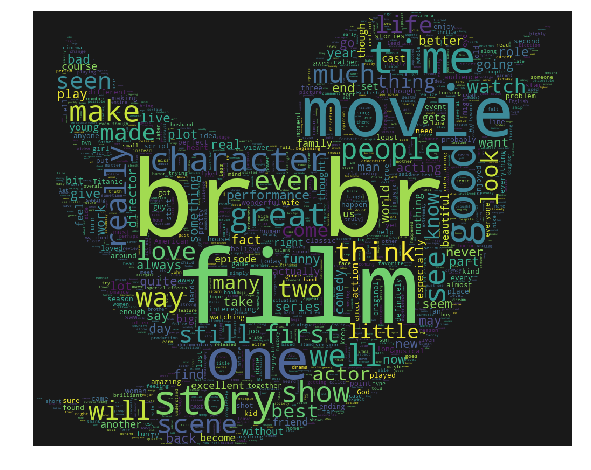

In [70]:
stopword=set(STOPWORDS)
clean_mask=np.array(Image.open("mask.png"))
clean_mask=clean_mask[:,:,1]
x='sentiment'
subset=train_df[train_df[x]==1][:1000]
text=subset.review.values
wc= WordCloud(background_color="black",max_words=2000,mask=clean_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(16,8))
plt.axis("off")
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=0), alpha=0.9)
plt.show()

In [14]:
train_text = train_df["review"]
test_text = test_df["review"]
all_text = pd.concat([train_text, test_text])
all_text.head(3)

0    Bromwell High is a cartoon comedy. It ran at t...
1    Homelessness (or Houselessness as George Carli...
2    Brilliant over-acting by Lesley Ann Warren. Be...
Name: review, dtype: object

In [15]:
# vectorize text, remove stopwords, apply tfidf and ngram
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    lowercase=False, # uper case could beuseful to reflect stronger emotion
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 3),  # 1,2,3 gram
    max_features=100)  # to save time i'm using 100, here we change to 10000 could boost performance in trade of time
#feature extraction using train and test text
word_vectorizer.fit(all_text)
print("word_vectoriezed....finished")
# text to tf-idf vector
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

word_vectoriezed....finished


In [16]:
# here we do a character feature vectrorization, this is to capture additional text info written in abbreviation or single char
scores = []
start_time = time.time()

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    
    stop_words='english',
    ngram_range=(2, 3),
    max_features=100)  #change to 10000 in final ver



char_vectorizer.fit(all_text)
print("char vectorizing....")
train_char_features = char_vectorizer.transform(train_text)
test_char_features = char_vectorizer.transform(test_text)



train_features = hstack([train_char_features, train_word_features])
test_features = hstack([test_char_features, test_word_features])


elapsed_time = time.time() - start_time
print("elapsed_time is:",elapsed_time)

char vectorizing....
elapsed_time is: 357.81976675987244


In [17]:
## use word N-gram Features
scores = []
start_time = time.time()

for class_name in ['sentiment']:
    train_target = train_df[class_name]
    classifier = LogisticRegression(C=0.1)

    cv_score = np.mean(cross_val_score(classifier, train_word_features, train_target, cv=3, scoring='accuracy'))
    scores.append(cv_score)
    #print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_word_features, train_target)
    #submission[class_name] = classifier.predict_proba(test_features)[:, 1]
print("here we use both word N-gram features")
print('Total cross-validation accuracy is {},using Logistic Regression'.format(np.mean(scores)))


elapsed_time = time.time() - start_time
print("elapsed_time is:",elapsed_time)

here we use both word N-gram features
Total cross-validation accuracy is 0.7126802107391658,using Logistic Regression
elapsed_time is: 0.6917037963867188


In [18]:
## use word N-gram Features # here we compare stochatic average gradient solver vs libliner's sgd
# typical 
scores = []
start_time = time.time()
for class_name in ['sentiment']:
    train_target = train_df[class_name]
    classifier = LogisticRegression(C=0.1, solver='sag')

    cv_score = np.mean(cross_val_score(classifier, train_word_features, train_target, cv=3, scoring='accuracy'))
    scores.append(cv_score)
    #print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_word_features, train_target)
    #submission[class_name] = classifier.predict_proba(test_features)[:, 1]
print("here we use both word N-gram features")
print('Total cross-validated accuracy is {},using Logistic Regression'.format(np.mean(scores)))


elapsed_time = time.time() - start_time
print("elapsed_time is:",elapsed_time)

here we use both word N-gram features
Total cross-validated accuracy is 0.7126001979371175,using Logistic Regression
elapsed_time is: 1.2917661666870117


In [19]:
## use both word and character N-gram features
scores = []
start_time = time.time()
#submission = pd.DataFrame.from_dict({'id': test['id']})
for class_name in ['sentiment']:
    train_target = train_df[class_name]
    classifier = LogisticRegression(C=0.1, solver='liblinear')

    cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='accuracy'))
    scores.append(cv_score)
    #print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_features, train_target)
    #submission[class_name] = classifier.predict_proba(test_features)[:, 1]
print("here we use both word and character N-gram features")
print('Total cross-validation acc score is {},using Logistic Regression'.format(np.mean(scores)))


elapsed_time = time.time() - start_time
print("elapsed_time is:",elapsed_time)
# here no much boost in adding char feature

here we use both word and character N-gram features
Total cross-validation acc score is 0.7258805757373303,using Logistic Regression
elapsed_time is: 2.256495952606201


for lamda is:  0.001
Total cross-validation accuracy is 0.7007596761438153,using Logistic Regression
elapsed_time is: 2.775022029876709
for lamda is:  0.1
Total cross-validation accuracy is 0.725600521329393,using Logistic Regression
elapsed_time is: 5.922613143920898
for lamda is:  0.5
Total cross-validation accuracy is 0.7330804414187432,using Logistic Regression
elapsed_time is: 13.413382291793823


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


for lamda is:  1
Total cross-validation accuracy is 0.736480515068156,using Logistic Regression
elapsed_time is: 14.012866020202637


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


for lamda is:  2
Total cross-validation accuracy is 0.7388404990970862,using Logistic Regression
elapsed_time is: 14.439413785934448


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


for lamda is:  5
Total cross-validation accuracy is 0.7418404991354892,using Logistic Regression
elapsed_time is: 14.338825702667236


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


for lamda is:  10
Total cross-validation accuracy is 0.7424404415385607,using Logistic Regression
elapsed_time is: 14.145398378372192


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


for lamda is:  100
Total cross-validation accuracy is 0.7426404255398406,using Logistic Regression
elapsed_time is: 13.87678575515747


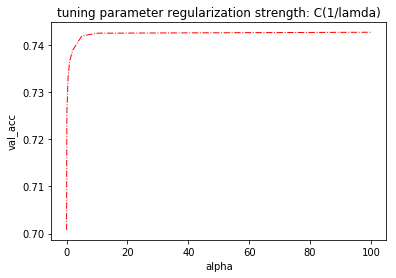

In [20]:
#tune for regularization
param_l=[]
error_l=[]
for lamda in [0.001,0.1,0.5,1,2,5,10,100]:
    scores = []
    start_time = time.time()

    for class_name in ['sentiment']:
        train_target = train_df[class_name]
        classifier = LogisticRegression(C=lamda,penalty="l2", solver='sag')

        cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='accuracy'))
        scores.append(cv_score)
            #print('CV score for class {} is {}'.format(class_name, cv_score))

        classifier.fit(train_features, train_target)

    print("for lamda is: ", lamda )
    print('Total cross-validation accuracy is {},using Logistic Regression'.format(np.mean(scores)))
    param_l.append(lamda)
    error_l.append(np.mean(scores))

    elapsed_time = time.time() - start_time
    print("elapsed_time is:",elapsed_time)

plt.title("tuning parameter regularization strength: C(1/lamda)")
plt.ylabel("val_acc")
plt.xlabel("alpha")
plt.plot(param_l, error_l, color="red", linewidth=1.0, linestyle="-.")

Try SVM using a linear kernal....Total CV accuracy is 0.6967594680759673
elapsed_time is: 0.7325105667114258
Try SVM using a linear kernal....Total CV accuracy is 0.7030796921747942
elapsed_time is: 1.772078514099121
Try SVM using a linear kernal....Total CV accuracy is 0.714226641673435
elapsed_time is: 3.074475049972534
Try SVM using a linear kernal....Total CV accuracy is 0.721580106044709
elapsed_time is: 6.570345401763916
Try SVM using a linear kernal....Total CV accuracy is 0.7258321859455277
elapsed_time is: 14.207928895950317
Try SVM using a linear kernal....Total CV accuracy is 0.7285335832118869
elapsed_time is: 54.901140451431274


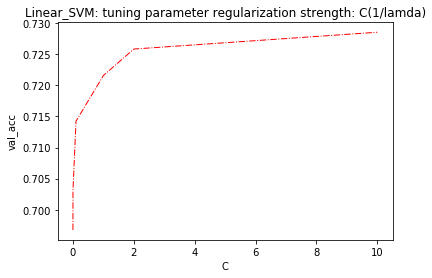

In [21]:
scores = []
start_time = time.time()
param_l=[]
error_l=[]
for param in [0.0001,0.001,0.1,1,2,10]:
    #submission = pd.DataFrame.from_dict({'id': test['id']})
    for class_name in ['sentiment']:
        train_target = train_df[class_name]
        classifier = LinearSVC(C=param)

        cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='accuracy'))
        scores.append(cv_score)
        #print('CV score for class {} is {}'.format(class_name, cv_score))


        #param_range = np.logspace(-6, -1, 5)
        #train_scores, test_scores = validation_curve(
        #SVC(), train_features, train_target, param_name="gamma", param_range=param_range,
        #cv=10, scoring="roc_auc")


        classifier.fit(train_features, train_target)
        #submission[class_name] = classifier.predict_proba(test_features)[:, 1]
    param_l.append(param)
    error_l.append(np.mean(scores))
    print('Try SVM using a linear kernal....Total CV accuracy is {}'.format(np.mean(scores)))
    elapsed_time = time.time() - start_time
    print("elapsed_time is:",elapsed_time)


plt.title("Linear_SVM: tuning parameter regularization strength: C(1/lamda)")
plt.ylabel("val_acc")
plt.xlabel("C")
plt.plot(param_l, error_l, color="red", linewidth=1.0, linestyle="-.")



In [ ]:
from sklearn.naive_bayes import MultinomialNB
###use only word-Ngram-features
param_l=[]
error_l=[]
for param in [[0.1,0.9],[0.2,0.8],[0.3,0.7],[0.5,0.5]]:
    scores = []
    start_time = time.time()
    #submission = pd.DataFrame.from_dict({'id': test['id']})
    for class_name in ['sentiment']:
        train_target = train_df[class_name]
        classifier = MultinomialNB(0.1,class_prior=param)

        cv_score = np.mean(cross_val_score(classifier, train_word_features, train_target, cv=3, scoring='accuracy'))
        scores.append(cv_score)
        ##print('CV score for class {} is {}'.format(class_name, cv_score))
        #train_scores, valid_scores = validation_curve(Ridge(), train_features, train_target, "alpha",np.logspace(-7, 3, 3))


        classifier.fit(train_word_features, train_target)

    print("for prior_class",param[0])
    print('Using naive bayes...Total CV acc score is {}'.format(np.mean(scores)))
    elapsed_time = time.time() - start_time
    print("elapsed_time is:",elapsed_time)
    param_l.append(param[0])
    error_l.append(np.mean(scores))
    print("-------------------------")
plt.title("Naive Bayes tuning parameter: Laplace Smoother")
plt.ylabel("acc")
plt.xlabel("Laplace Smoother")
plt.plot(param_l, error_l, color="red", linewidth=1.0, linestyle="-.")


In [23]:
# A embedding and LSTM BASELINE
# update keras and run.

In [54]:
EMBEDDING_FILE = ('C:\\Users\\hudie\\Documents\\project_code\\glove.840B.300d.txt')
train = train_df
test = test_df

In [55]:
from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot_acc = PlotLearning()

In [56]:
X_train = train["review"].str.lower()
y_train = train[["sentiment"]].values

X_test = test["review"].str.lower()

In [57]:
max_features=50000
maxlen=150
embed_size=300

class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

In [58]:
tok=text.Tokenizer(num_words=max_features,lower=True)
tok.fit_on_texts(list(X_train)+list(X_test))
X_train=tok.texts_to_sequences(X_train)
X_test=tok.texts_to_sequences(X_test)
x_train=sequence.pad_sequences(X_train,maxlen=maxlen)
x_test=sequence.pad_sequences(X_test,maxlen=maxlen)
embeddings_index = {}
with open(EMBEDDING_FILE,encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
        
        
word_index = tok.word_index
#prepare embedding matrix
num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embed_size))
for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [59]:
from keras.models import Sequential

In [65]:

sequence_input = Input(shape=(maxlen, ))
x = Embedding(max_features, embed_size, weights=[embedding_matrix],trainable = False)(sequence_input)
x = SpatialDropout1D(0.2)(x)  # droupout regulirization
x = Bidirectional(GRU(256, return_sequences=True,dropout=0.15,recurrent_dropout=0.1))(x)
x = Bidirectional(GRU(128, return_sequences=True))(x)
x = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool]) 
###consider droput regulirization
# x = Dropout(0.1)(x)
###
#loss_batch, _, summary = sess.run([model.loss, model.optimizer, model.summary_op],feed_dict=feed_dict)
#writer.add_summary(summary, global_step=step)
###t

preds = Dense(1, activation="sigmoid")(x)
model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-3),metrics=['accuracy'])

In [66]:
batch_size = 128
epochs = 3
X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=233)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [67]:

filepath="weights_base.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early = EarlyStopping(monitor="val_acc", mode="max", patience=5)
ra_val = RocAucEvaluation(validation_data=(X_val, y_val), interval = 1)
callbacks_list = [ra_val,checkpoint, early]

In [71]:
model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),callbacks=callbacks_list,verbose=1)
#Loading model weights
print("Fitting finished...")
#model.load_weights(filepath)
print('Predicting....')
y_pred = model.predict(x_test,batch_size=300
                       ,verbose=1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/3
22500/22500 [==============================] - 1473s 65ms/step - loss: 0.3099 - accuracy: 0.8704 - val_loss: 0.2852 - val_accuracy: 0.8812

 ROC-AUC - epoch: 1 - score: 0.950880
Epoch 2/3


C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


22500/22500 [==============================] - 1266s 56ms/step - loss: 0.2604 - accuracy: 0.8920 - val_loss: 0.3033 - val_accuracy: 0.8668

 ROC-AUC - epoch: 2 - score: 0.952487
Epoch 3/3
22500/22500 [==============================] - 1373s 61ms/step - loss: 0.2506 - accuracy: 0.8966 - val_loss: 0.2816 - val_accuracy: 0.8800

 ROC-AUC - epoch: 3 - score: 0.952495
Fitting finished...
Predicting....
25000/25000 [==============================] - 372s 15ms/step


In [ ]:
#error ana
#short long? jst too diff?

#does 